# Week8 basic 

lora finetuning 기법을 적용할 예정입니다.

r = 8, 128, 256, 2048로 메모리 사용량을 비교할 것입니다.

나아가 wandb로 훈련 추이를 비교할 것입니다.

아래는 r = 2048일 때의 예시 코드입니다. r값을 제외하면 나머지는 동일합니다.

데이터는 전체의 1%만 사용하여 코드를 작성하였고 모델은 "meta-llama/Llama-3.2-1B"를 사용하였습니다.

In [24]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
import wandb
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
import torch

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(base_model).to(device)

tokenizer.pad_token = tokenizer.eos_token 
r = 2048

wandb.init(project="lora-llama-exp", name=f"llama-1b-lora-{r}")
peft_config = LoraConfig(r=r, lora_alpha=16, lora_dropout=0.1, inference_mode=False, task_type=TaskType.CAUSAL_LM)
model = get_peft_model(model, peft_config)


In [25]:
dataset = load_dataset("sahil2801/CodeAlpaca-20k", split="train")
nums = 3
print("1. Instruction 형태")
print(dataset.select(range(nums))['instruction'], end="\n\n")

print("2. Input 형태")
print(dataset.select(range(nums))['input'], end="\n\n")

print("3. Output 형태")
print(dataset.select(range(nums))['output'], end="\n\n")

1. Instruction 형태
['Create an array of length 5 which contains all even numbers between 1 and 10.', 'Formulate an equation to calculate the height of a triangle given the angle, side lengths and opposite side length.', 'Write a replace method for a string class which replaces the given string with a given set of characters.']

2. Input 형태
['', '', 'string = "Hello World!"\nreplace_with = "Greetings!"']

3. Output 형태
['arr = [2, 4, 6, 8, 10]', 'Height of triangle = opposite side length * sin (angle) / side length', 'def replace(self, replace_with):\n    new_string = ""\n    for char in self:\n        if char == " ":\n            new_string += replace_with\n        else:\n            new_string += char\n    return new_string']



In [26]:
def format_llama_prompt(example):
    prompt = f"### 질문: {example['instruction']} + {example['input']}\n### 답변: {example['output']}"
    return {"text": prompt}

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset = dataset.map(format_llama_prompt).map(tokenize_function, batched=True)
train_dataset = dataset.select(range(200))
val_dataset = dataset.select(range(200,250))
test_dataset = dataset.select(range(250,300))

In [27]:
sft_config = SFTConfig(
    output_dir=f"/tmp/llama-lora-{r}", 
    max_seq_length=128,
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb", 
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=sft_config,
    formatting_func=lambda x: x["text"],
)

/workspace/streamGPT/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/workspace/streamGPT/.venv/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:359: UserWarning: You passed a dataset that is already processed (contains an `input_ids` field) together with a valid formatting function. Therefore `formatting_func` will be ignored. Either remove the `formatting_func` or pass a dataset that is not already processed.
  warnings.warn(


In [28]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss
1,1.734000,1.647899
2,1.677200,1.632199
3,1.659300,1.615021
4,1.657000,1.598703
5,1.640900,1.583771
6,1.614200,1.571431
7,1.612400,1.562702
8,1.630300,1.556997


In [29]:
print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')

Max Alloc: 18.5 GB


In [30]:
wandb.finish()

eval/loss,█▇▅▄▃▂▁▁▁
eval/runtime,▇▄▅▁▂▄█▄▇
eval/samples_per_second,▂▅▄██▅▁▅▂
eval/steps_per_second,▂▅▄██▅▁▅▃
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇▇▇███
train/grad_norm,▅▁▂▃▅▅▇▅█
train/learning_rate,█▇▆▅▄▃▂▂▁
train/loss,█▅▅▅▄▃▂▁▃
eval/loss,1.557
eval/runtime,0.9972


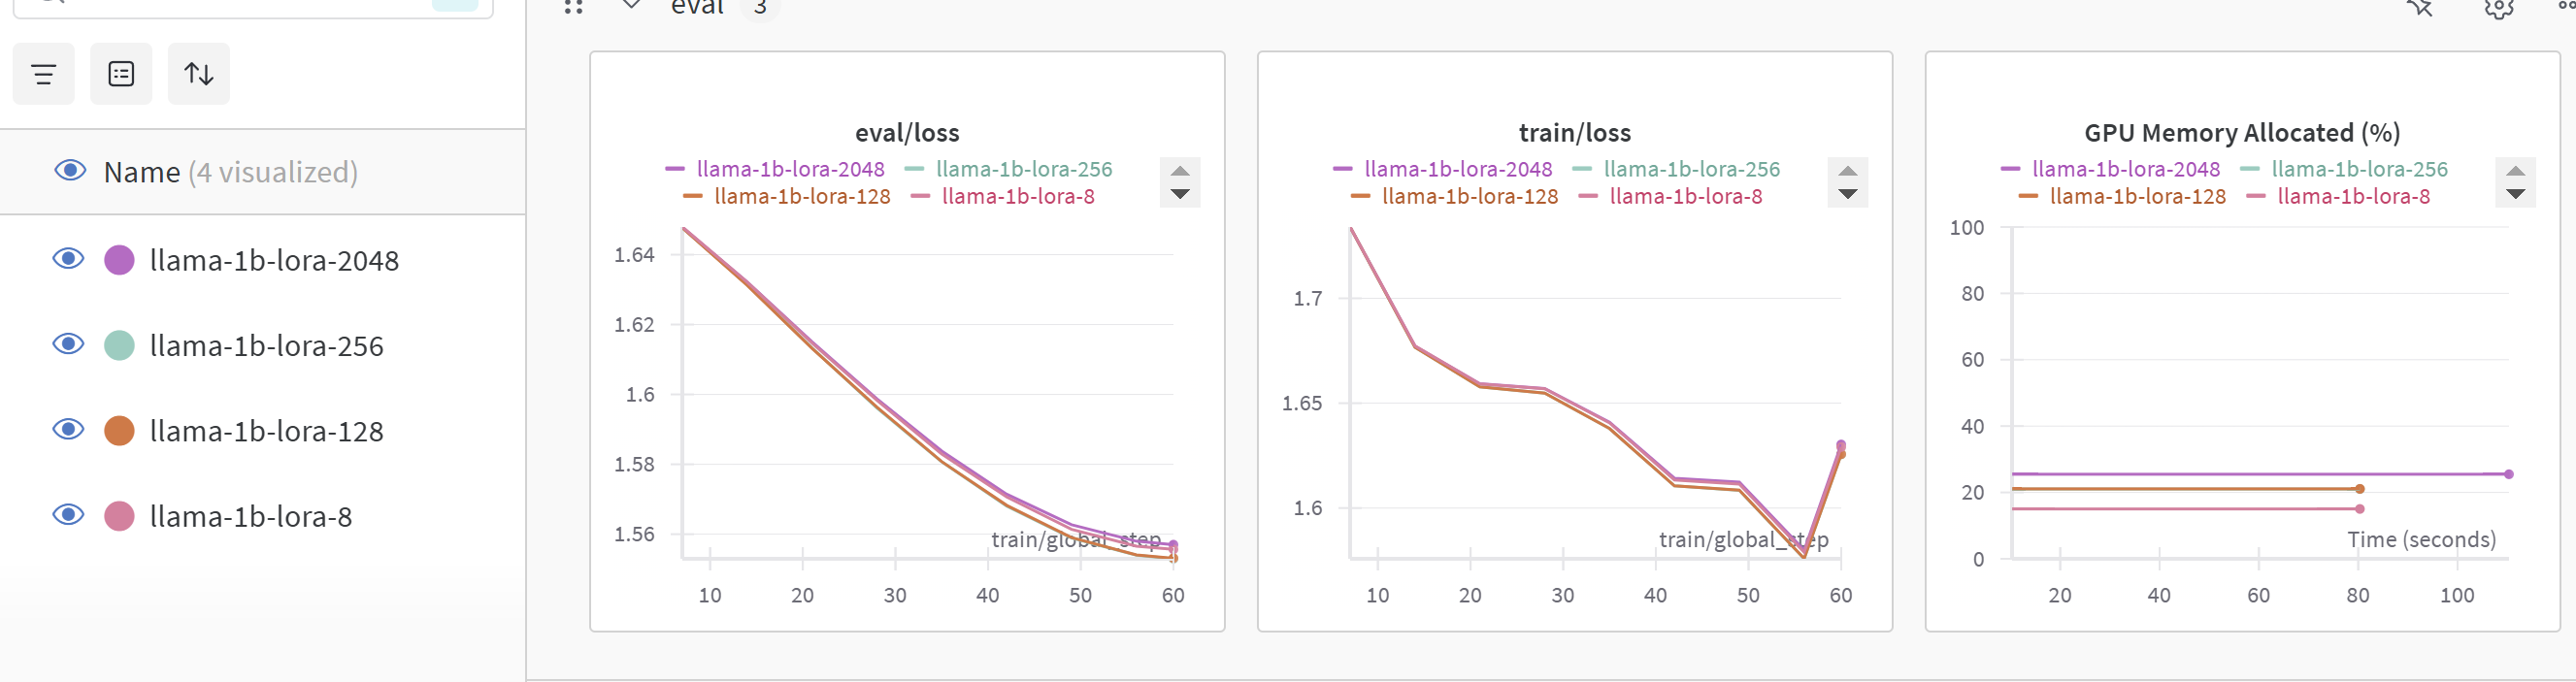

# 결론

- 확실히 메모리 사용량이 r값이 증가함에 따라 올라가는 것을 확인할 수 있습니다.

- 데이터의 양을 많이 줄였기 때문에 오버피팅이 나기 전에 모두 종료가 되었습니다. 